In [179]:
#!pip install spotify
#!pip install base64
#!pip install lyricsgenius

import spotify.sync as spotify
import base64
import datetime
import requests
from urllib.parse import urlencode
import pandas as pd
import os
current_path = os.getcwd()
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing

In [244]:

# Setting up spotify credentials
spotify_client_id = '4f8887d2b1b8440a80b2135fcb761224'
spotify_client_secret = 'a9c1279440f641dd8cb8357d662d26ef'
spotify_client_creds = f'{spotify_client_id}:{spotify_client_secret}'
spotify_client_creds_b64 = base64.b64encode(spotify_client_creds.encode())
    
# Using client ID and secret to get a token to be used for each requests
# https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow
spotify_token_url = 'https://accounts.spotify.com/api/token' 
spotify_token_data = {
    'grant_type': 'client_credentials'
}

spotify_token_headers = {
    'Authorization': f"Basic {spotify_client_creds_b64.decode()}" #<base64 encoded client_id:client_secret>
}

# Get the token with a POST request
r = requests.post(spotify_token_url, data=spotify_token_data, headers=spotify_token_headers)
valid_request = r.status_code in range(200, 299)
if valid_request:
#     now = datetime.datetime.now
    spotify_access_token = r.json()['access_token']
#     expires_in = r.json()['expires_in'] # in seconds
#     expires = now + datetime.timedelta(seconds=expires_in)
#     did_expire = expires < now

spotify_headers = {
    "Authorization": f"Bearer {spotify_access_token}"
}

In [144]:
# define function to lookup the artist and return the dictionary for the first match
def find_artist(artist_search):
    lookup_url_artist = f"https://api.spotify.com/v1/search?q={artist_search}&type=artist"
    nike_artists = requests.get(lookup_url_artist, headers=spotify_headers)
    if nike_artists.status_code == 200:
        artist_json_file = nike_artists.json()
        artist = artist_json_file['artists']['items'][0]
        artists_dict['artist_id'] = artist['id']
        artists_dict['artist_name'] = artist['name']
        artists_dict['followers'] = artist['followers']['total']
        artists_dict['genres'] = artist['genres']
        artists_dict['popularity'] = artist['popularity']
    else:
        print(nike_artists.status_code)
    return artists_dict

In [145]:
def find_artist_tracks(artist_id):
    markets = ['US', 'GB']
    track_list = []
    for m in markets:
        lookup_url_toptracks = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?market={m}"
        artist_toptracks = requests.get(lookup_url_toptracks, headers=spotify_headers)
        if artist_toptracks.status_code == 200:
            toptracks_json_file = artist_toptracks.json()
            for t in toptracks_json_file['tracks']:
                track_list.append(t['id'])
        else:
            print (artist_toptracks.status_code)
    return set(track_list)
#ttps://api.spotify.com/v1/artists/{id}/top-tracks

In [146]:
def track_popularity(track_id):
    lookup_url_trackpop = f"https://api.spotify.com/v1/tracks/{track_id}"
    track_pop = requests.get(lookup_url_trackpop, headers=spotify_headers)
    if track_pop.status_code == 200:
        tracks_pop_json_file = track_pop.json()
        return(tracks_pop_json_file['popularity'])
    else:
        print (track_pop.status_code)
        return

In [147]:
def get_audio_features(track_ids):
    audio_features_cols = ["energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","trackid","time_signature"]
    df_audio_features = pd.DataFrame(columns=audio_features_cols)
    for t in track_ids:
        t_id = str(t)
        lookup_url_audio = f"https://api.spotify.com/v1/audio-features/{t_id}"
        audio_features = requests.get(lookup_url_audio, headers=spotify_headers)
        audio_features_dict = {"danceability": None,"energy": None,"key": None,"loudness": None,"mode": None,"speechiness": None,"acousticness": None,"instrumentalness": None,"liveness": None,"valence": None,"tempo": None,"trackid": None,"time_signature": None}
        if audio_features.status_code == 200:
            audio_features_json_file = audio_features.json()
            audio_features_dict['trackid'] = audio_features_json_file['id']
            audio_features_dict['danceability'] = audio_features_json_file['danceability']
            audio_features_dict['energy'] = audio_features_json_file['energy']
            audio_features_dict['key'] = audio_features_json_file['key']
            audio_features_dict['loudness'] = audio_features_json_file['loudness']
            audio_features_dict['mode'] = audio_features_json_file['mode']
            audio_features_dict['speechiness'] = audio_features_json_file['speechiness']
            audio_features_dict['acousticness'] = audio_features_json_file['acousticness']
            audio_features_dict['instrumentalness'] = audio_features_json_file['instrumentalness']
            audio_features_dict['liveness'] = audio_features_json_file['liveness']
            audio_features_dict['valence'] = audio_features_json_file['valence']
            audio_features_dict['tempo'] = audio_features_json_file['tempo']
            audio_features_dict['time_signature'] = audio_features_json_file['time_signature']
            df_audio_features = df_audio_features.append(audio_features_dict, ignore_index=True)
        else:
            print('problem with ', t, " error: ", audio_features.status_code)
    return df_audio_features



In [246]:
# Define dictionary and database for artists
artists_dict = {'artist_id': None, 'artist_name': None, 'followers': None, 'genres': None, 'popularity': None}

columns_artists = ['artist_id', 'artist_name', 'followers', 'genres', 'popularity']

df_artists = pd.DataFrame(columns=columns_artists)

In [247]:
artist_list = ["Billie Eilish", "Drake", "Travis Scott", "Skepta", "G Dragon", "Kendrick Lamar", "Koffee", "Rosalia"]
for a in artist_list:
    b = a.replace(" ", "%20")
    artist_data = find_artist(b)
    df_artists = df_artists.append(artist_data, ignore_index=True)
df_artists.sort_values(by = 'followers', ascending = False)

,artist_id,artist_name,followers,genres,popularity
1,3TVXtAsR1Inumwj472S9r4,Drake,55974994,"[canadian hip hop, canadian pop, hip hop, pop ...",98
0,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,46198045,"[electropop, pop]",93
5,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,17800331,"[conscious hip hop, hip hop, rap, west coast rap]",89
2,0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,17490594,"[rap, slap house]",94
7,7ltDVBr6mKbRvohxheJ9h1,ROSALÍA,4755576,[r&b en espanol],83
4,30b9WulBM8sFuBo17nNq9c,G-DRAGON,2387171,"[k-pop, k-rap]",64
3,2p1fiYHYiXz9qi0JJyxBzN,Skepta,937269,"[birmingham grime, grime, instrumental grime, ...",78
6,1gWjcmBsveEYMxOZ0VRi32,Koffee,442238,"[dancehall, modern reggae]",66


In [249]:
df_artists_sort = df_artists.sort_values(by = 'artist_name')

In [250]:
df_artists.followers = df_artists.followers.astype(float)
df_artists.popularity = df_artists.popularity.astype(float)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Billie Eilish'),
  Text(1, 0, 'Drake'),
  Text(2, 0, 'G-DRAGON'),
  Text(3, 0, 'Kendrick Lamar'),
  Text(4, 0, 'Koffee'),
  Text(5, 0, 'ROSALÍA'),
  Text(6, 0, 'Skepta'),
  Text(7, 0, 'Travis Scott')])

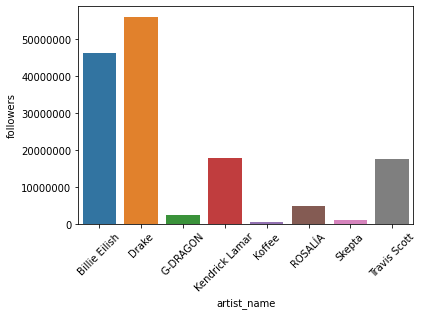

In [252]:
sns.barplot(x='artist_name',
            y="followers", 
            data=df_artists, 
            order=df_artists.sort_values('artist_name').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Billie Eilish'),
  Text(1, 0, 'Drake'),
  Text(2, 0, 'G-DRAGON'),
  Text(3, 0, 'Kendrick Lamar'),
  Text(4, 0, 'Koffee'),
  Text(5, 0, 'ROSALÍA'),
  Text(6, 0, 'Skepta'),
  Text(7, 0, 'Travis Scott')])

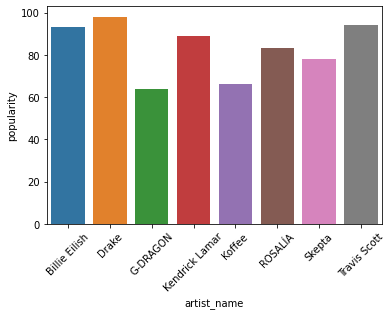

In [253]:
sns.barplot(x='artist_name',
            y="popularity", 
            data=df_artists, 
            order=df_artists.sort_values('artist_name').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)

In [262]:
df_artists['twitter_followers'] = ['6000000', '39100000', '8600000', '11400000', '156000', '2600000', '1100000', '11000000']
df_artists['twitter_followers'] = df_artists['twitter_followers'].astype(float)

In [277]:
df_artists_mills = df_artists[['artist_name', 'followers']]
df_artists_mills['spotify followers (mill)'] = df_artists.followers / 100000
df_artists_mills['twitter followers (mill)'] = df_artists['twitter_followers'] / 100000

<ipython-input-277-41e5c10d06e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artists_mills['spotify followers (mill)'] = df_artists.followers / 100000
<ipython-input-277-41e5c10d06e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artists_mills['twitter followers (mill)'] = df_artists['twitter_followers'] / 100000


In [278]:
df_artists_mills.head()

,artist_name,followers,spotify followers (mill),twitter followers (mill)
0,Billie Eilish,"46,198,045.00",461.98,60.00
1,Drake,"55,974,994.00",559.75,391.00
2,Travis Scott,"17,490,594.00",174.91,86.00
3,Skepta,"937,269.00",9.37,114.00
4,G-DRAGON,"2,387,171.00",23.87,1.56


(0.0, 600.0)

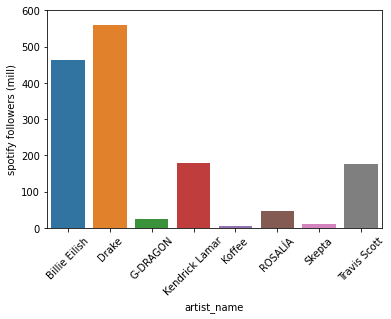

In [285]:
sns.barplot(x='artist_name',
            y="spotify followers (mill)", 
            data=df_artists_mills, 
            order=df_artists_mills.sort_values('artist_name').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)
plt.gcf().axes[0].set_ylim([0,600])

In [264]:
df_artists.describe()

,followers,popularity,twitter_followers
count,8.00,8.00,8.00
mean,"18,248,277.25",83.12,"9,994,500.00"
std,"21,565,922.63",12.86,"12,527,706.97"
min,"442,238.00",64.00,"156,000.00"
25%,"2,024,695.50",75.00,"2,225,000.00"
50%,"11,123,085.00",86.00,"7,300,000.00"
75%,"24,899,759.50",93.25,"11,100,000.00"
max,"55,974,994.00",98.00,"39,100,000.00"


(0.0, 600.0)

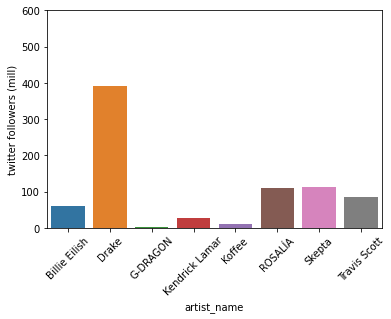

In [286]:
sns.barplot(x='artist_name',
            y="twitter followers (mill)", 
            data=df_artists_mills, 
            order=df_artists_mills.sort_values('artist_name').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)
plt.gcf().axes[0].set_ylim([0,600])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Billie Eilish'),
  Text(1, 0, 'Drake'),
  Text(2, 0, 'Travis Scott'),
  Text(3, 0, 'Skepta'),
  Text(4, 0, 'G-DRAGON'),
  Text(5, 0, 'Kendrick Lamar'),
  Text(6, 0, 'Koffee'),
  Text(7, 0, 'ROSALÍA')])

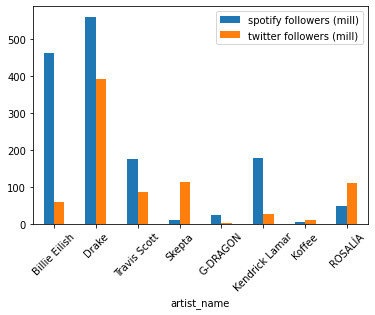

In [282]:
df_artists_mills[['artist_name', 'spotify followers (mill)', 'twitter followers (mill)']].set_index('artist_name').plot.bar()
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.xticks(rotation = 45)

In [156]:
#get top songs for each artist (based off UK and US markets)
track_ids = []
artist_id_list = df_artists.artist_id
for a in artist_id_list:
    listoftracks = find_artist_tracks(a)
    for l in listoftracks:
        track_ids.append(l)


In [157]:
audio_data = get_audio_features(track_ids)
audio_data

,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,trackid,time_signature,danceability
0,0.30,4,-10.11,0,0.03,0.93,0,0.10,0.12,115.28,0u2P5u6lvoDfwTYjAADbn4,4,0.35
1,0.36,4,-7.65,0,0.04,0.82,0.03,0.08,0.17,144.89,6cX5gpmE7PW5FZXzAmW7vK,4,0.51
2,0.37,8,-9.91,1,0.07,0.33,0.54,0.11,0.59,85.02,6uqyE384HDSsuwpoF4mjrL,4,0.77
3,0.37,4,-7.72,0,0.04,0.82,0.06,0.08,0.16,144.83,2uIX8YMNjGMD7441kqyyNU,4,0.47
4,0.23,6,-14.45,0,0.10,0.90,0.66,0.11,0.24,120.01,3ZCTVFBt2Brf31RLEnCkWJ,4,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.69,5,-5.79,0,0.06,0.01,0.00,0.09,0.25,170.90,7MXgrcOQAJ5VwSNUL0lDd3,4,0.49
81,0.62,7,-4.89,1,0.29,0.03,0,0.09,0.39,81.99,2XIc1pqjXV3Cr2BQUGNBck,4,0.86
82,0.36,0,-8.89,0,0.05,0.74,0.00,0.10,0.36,80.06,1zZ7vl1amOLI4GE5oUn0YB,4,0.71
83,0.48,0,-4.78,0,0.09,0.55,0.02,0.08,0.53,97.97,1B0BQaSRHxhI0AUlItY3LK,4,0.89


In [158]:
pop_list = []
for t in track_ids:
    track_pop = track_popularity(t)
    pop_list.append(track_pop)
audio_data['popularity'] = pop_list

In [159]:
audio_data.dtypes

energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness     object
liveness            float64
valence             float64
tempo               float64
trackid              object
time_signature       object
danceability        float64
popularity            int64
dtype: object

In [202]:
# Transform column to numeric
#audio_data.loc[:, 'popularity'] = pd.to_numeric(audio_data.loc[:, ('popularity')])
audio_data.loc[:, 'instrumentalness'] = pd.to_numeric(audio_data.loc[:, ('instrumentalness')])
audio_data.loc[:, 'mode'] = pd.to_numeric(audio_data.loc[:, ('mode')])

In [203]:
audio_data_plot = audio_data[['popularity', 'tempo', 'valence', 'liveness', 'instrumentalness', 'acousticness', 'loudness', 'energy', 'danceability']]

In [204]:
audio_data_plot.dtypes

popularity            int64
tempo               float64
valence             float64
liveness            float64
instrumentalness    float64
acousticness        float64
loudness            float64
energy              float64
danceability        float64
dtype: object

9
0
popularity
1
tempo
2
valence
3
liveness
4
instrumentalness
5
acousticness
6
loudness
7
energy
8
danceability
9
10
11


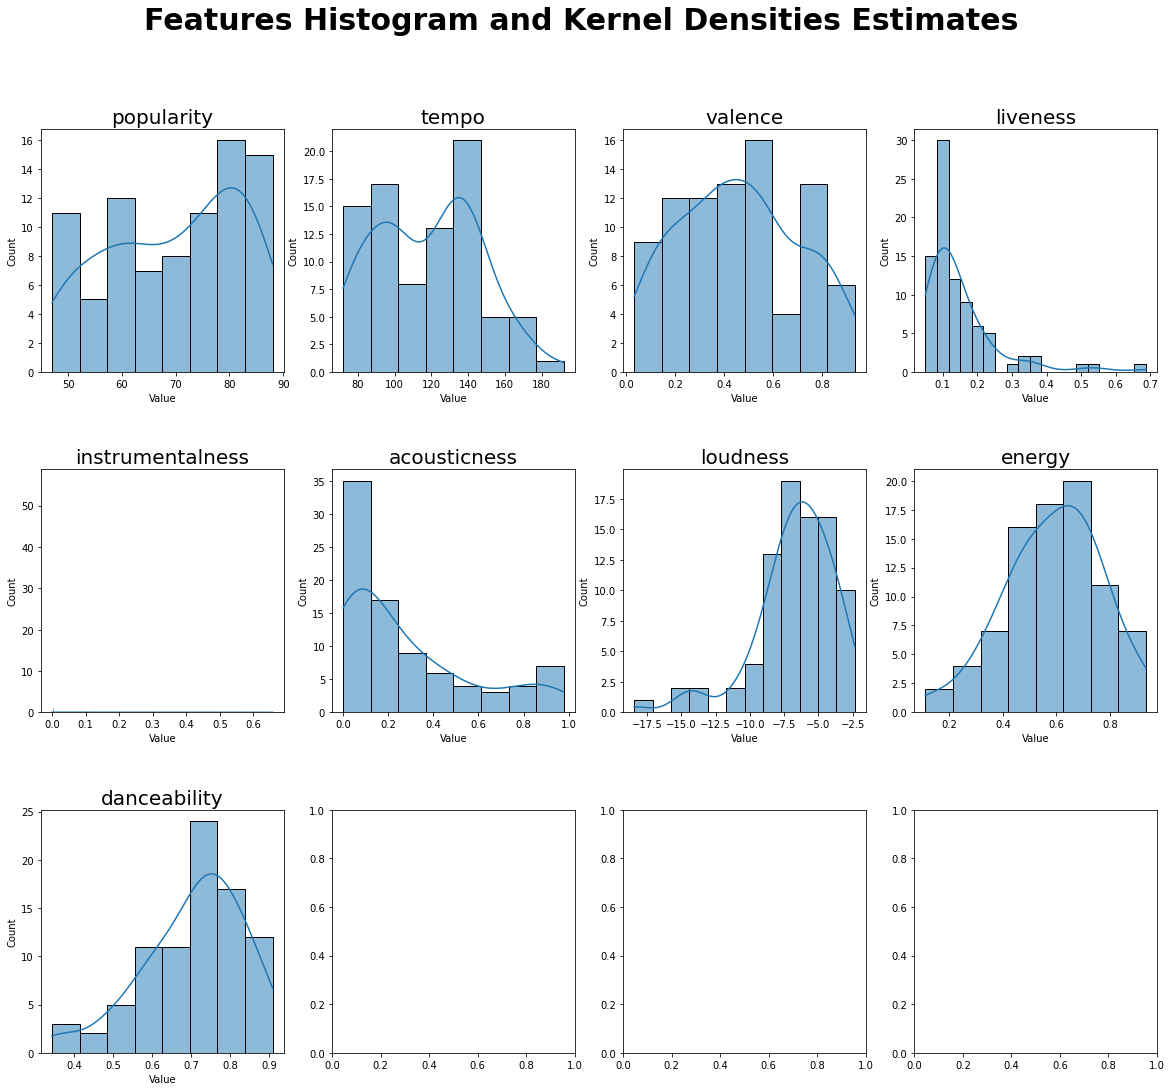

In [205]:
# Set rows and columns
nrows = 3
ncols = 4
tot_num_features = len(audio_data_plot.columns)
print(tot_num_features)

# Create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 17))
plt.subplots_adjust(hspace=0.4)
for row in range(nrows):
    for col in range(ncols):
        i = ncols * row + col
        print (i)
        if i < tot_num_features:
            feature = audio_data[audio_data_plot.columns].columns[i]
            print(feature)
            sns.histplot(audio_data[audio_data_plot.columns][feature], kde=True, ax=ax[row,col])
            ax[row, col].set_title(label=f'{feature}', fontsize=20)
            ax[row, col].set(xlabel='Value', ylabel='Count')
        else:
            pass
plt.suptitle('Features Histogram and Kernel Densities Estimates', fontsize=30, weight='bold')
plt.show()


In [206]:
audio_data.describe()

,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability,popularity
count,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00
mean,0.59,-6.74,0.53,0.18,0.28,0.02,0.15,0.46,118.01,0.70,69.76
std,0.18,2.93,0.50,0.13,0.29,0.09,0.11,0.24,28.43,0.13,12.48
min,0.11,-18.43,0.00,0.03,0.00,0.00,0.05,0.03,71.99,0.34,47.00
25%,0.46,-7.85,0.00,0.07,0.05,0.00,0.09,0.26,94.63,0.63,59.00
50%,0.61,-6.44,1.00,0.13,0.17,0.00,0.11,0.45,122.95,0.72,72.00
75%,0.72,-4.72,1.00,0.29,0.42,0.00,0.16,0.60,139.86,0.80,81.00
max,0.93,-2.35,1.00,0.49,0.98,0.66,0.69,0.93,192.00,0.91,88.00


In [207]:
audio_data_plot.isna().sum()

popularity          0
tempo               0
valence             0
liveness            0
instrumentalness    0
acousticness        0
loudness            0
energy              0
danceability        0
dtype: int64

In [211]:
audio_data_plot = audio_data_plot[['popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

In [235]:
# Function to normalize column of a dataset
def normalize_df(df):
    columns = df.columns.to_list()
    index = df_radar_chart.index
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=columns, index=index)

In [216]:
pwd

'/Users/JMo127/Ambassador_lyrics'

In [220]:
df_tot_tracks = pd.read_csv('top_100_songs.csv', index_col=[0])
df_tot_tracks

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
id,,,,,,,,,,,,,,,,,,,
4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021-03-19,0.68,0.70,0,-6.18,1,0.12,0.32,0.00,0.42,0.46,90.03,4
7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.58,0.44,10,-8.76,1,0.06,0.72,0.00,0.10,0.13,143.87,4
3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.78,0.69,4,-6.87,0,0.09,0.17,0.00,0.15,0.47,150.00,4
5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.68,0.83,0,-5.49,1,0.03,0.02,0.00,0.54,0.64,118.05,4
6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.65,0.52,11,-9.02,0,0.05,0.11,0.00,0.20,0.55,83.97,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7r9ZhitdQBONTFOiJW5mr8,Reloj,87,231595,1,"['Rauw Alejandro', 'Anuel AA']","['1mcTU81TzQhprhouKaTkpq', '2R21vXR83lH98kGeO9...",2020-10-22,0.82,0.54,8,-2.64,1,0.21,0.18,0.00,0.12,0.61,175.95,4
4VXIryQMWpIdGgYR4TrjT1,All Girls Are The Same,87,165820,1,['Juice WRLD'],['4MCBfE4596Uoi2O4DtmEMz'],2018-12-10,0.67,0.53,0,-7.23,1,0.31,0.08,0.00,0.09,0.20,161.99,4
58pgi1RpcU2fVJsxhm7BIr,Tapão Na Raba,87,175047,0,['Raí Saia Rodada'],['0NiaKn55OzJswiYevvlKfz'],2021-01-22,0.81,0.80,1,-3.17,1,0.03,0.46,0.00,0.15,0.80,128.05,4


[0.4295227524972253, 0.5818044259504445, 0.5803873918947894, 0.7265996417212006, 0.2829423087590635, 0.029919113080848783, 0.14087440595272924, 0.45741935483870977, 0.3840284854773918]


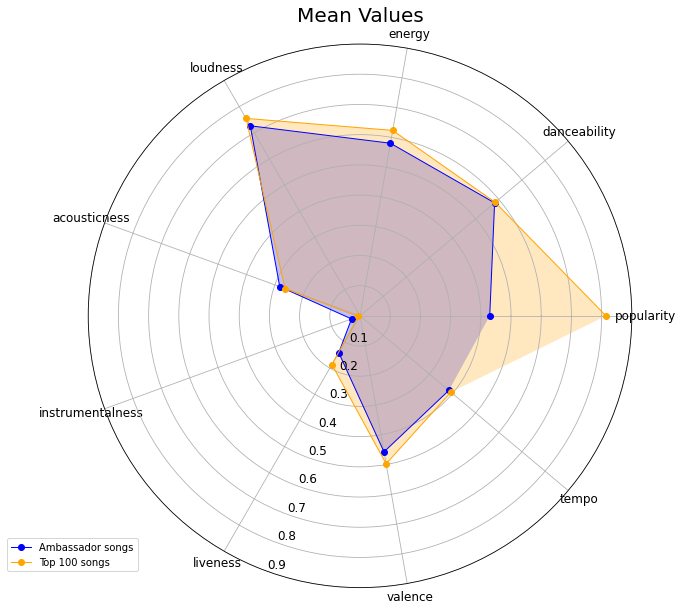

In [236]:
# Merge running songs and popular in the same dateset, so possible to normalize them
df_radar_chart = pd.concat([audio_data_plot[audio_data_plot.columns], df_tot_tracks[audio_data_plot.columns]], keys=['ambassadors', 'popular'])

# Normalize data
df_radar_chart_norm = normalize_df(df_radar_chart)

## Get means
mean_ambassador = df_radar_chart_norm.filter(like = 'ambassadors', axis=0).mean().tolist()
mean_popular = df_radar_chart_norm.filter(like = 'popular', axis=0).mean().tolist()
print(mean_ambassador)
# Set the figure
angles = np.linspace(0, 2*np.pi, len(df_radar_chart.columns), endpoint=False)
fig = plt.figure(figsize = (22, 22))

# Set axis
ax = fig.add_subplot(221, polar=True)
ax.plot(angles, mean_ambassador, 'o-', linewidth=1, label = "Ambassador songs", color='blue')
ax.fill(angles, mean_ambassador, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, df_radar_chart.columns, fontsize = 12)

ax.set_rlabel_position(250)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7', 
                                                            '0.8', '0.9'], size=12)
plt.ylim(0, 0.9)

ax.plot(angles, mean_popular, 'o-', linewidth=1, label = "Top 100 songs", color='orange')
ax.fill(angles, mean_popular, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values', fontsize = 20)
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))


In [237]:
# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
data_scaled = scale(audio_data_plot[['energy', 'loudness', 'valence', 'tempo', 'danceability', 'popularity']])
data_scaled

array([[-1.63262026e+00, -1.15441990e+00, -1.38755452e+00,
        -9.65589102e-02, -2.71717646e+00,  1.30881261e+00],
       [-1.25885549e+00, -3.10815602e-01, -1.18604245e+00,
         9.51001724e-01, -1.48866582e+00, -1.59333709e+00],
       [-1.20306971e+00, -1.08786470e+00,  5.45316330e-01,
        -1.16750639e+00,  4.61594804e-01,  1.47004315e+00],
       [-1.21980544e+00, -3.36545705e-01, -1.23539235e+00,
         9.48737340e-01, -1.76508072e+00, -4.64723318e-01],
       [-2.02869934e+00, -2.64505050e+00, -8.81718108e-01,
         7.05101696e-02, -6.77487481e-03,  1.06696680e+00],
       [-1.40947712e+00, -6.00365023e-01,  2.49216965e-01,
        -1.52004266e+00, -2.60155193e-01,  1.30881261e+00],
       [-9.12983617e-01, -1.44808613e+00,  4.30166577e-01,
         6.05541645e-01, -2.98094492e-02,  1.22819734e+00],
       [-2.66465731e+00, -2.51811533e+00, -1.06678021e+00,
        -1.25146550e+00, -2.59432539e+00,  9.86351532e-01],
       [-1.38716280e+00, -3.53012971e-01,  1.063

In [238]:
model = KMeans(n_clusters = 3, random_state= 123)
model

KMeans(n_clusters=3, random_state=123)

In [239]:
model.fit(data_scaled)

KMeans(n_clusters=3, random_state=123)

In [240]:
model.labels_

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [241]:
audio_data_plot["cluster"] = model.labels_.astype(int)

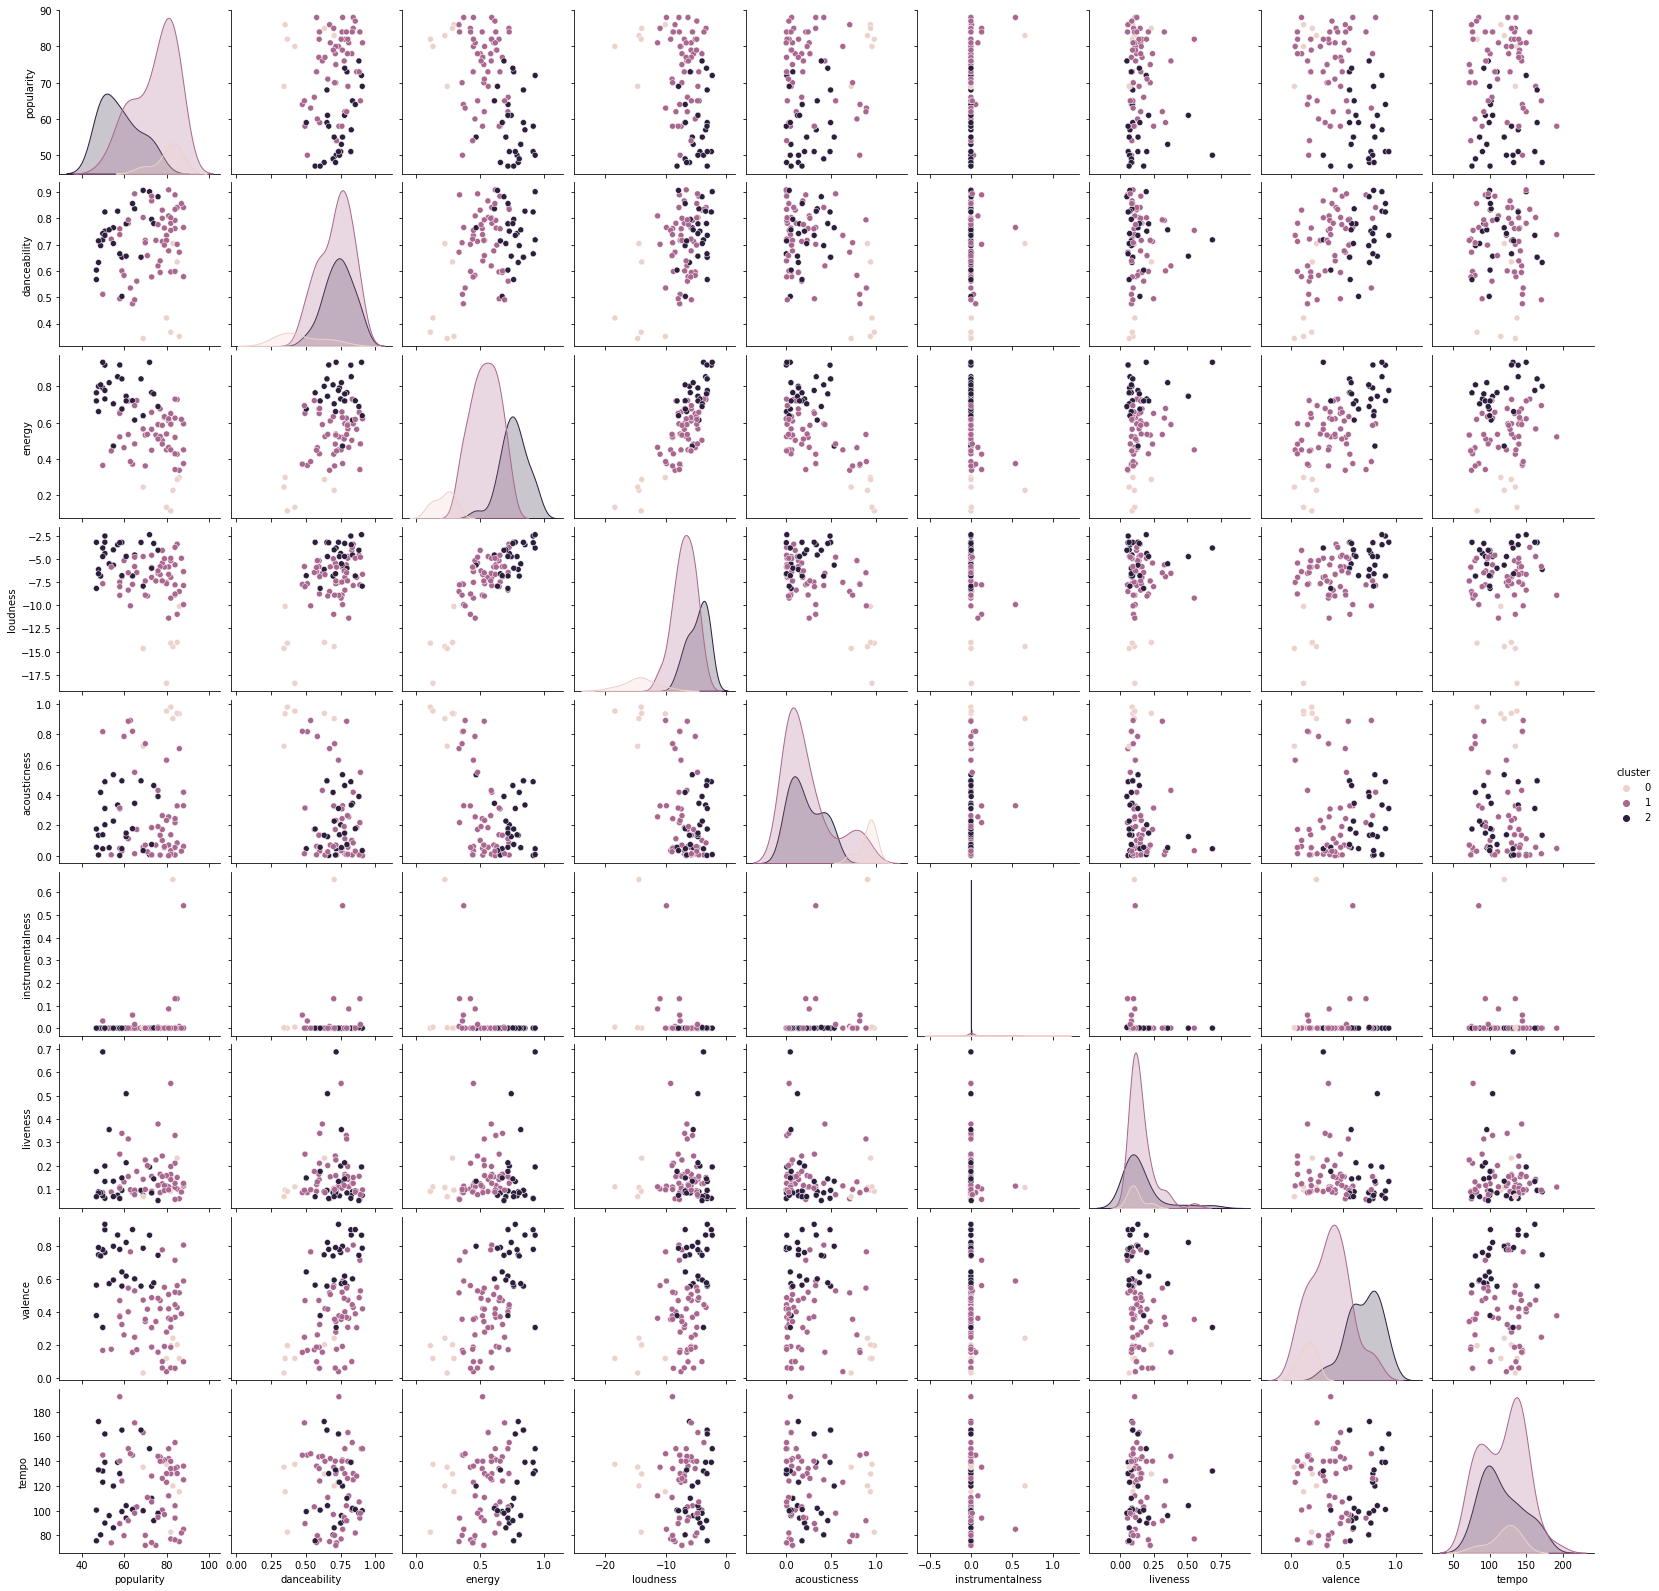

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt
pair = sns.pairplot(audio_data_plot, hue="cluster")
pair